<a href="https://colab.research.google.com/github/SucyLi/cSRM/blob/master/cSRM_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
import os
os.chdir('/gdrive/My Drive/CMI/Ting/SRM')
!python3 -m pip install brainiak

     |████████████████████████████████| 6.3MB 12.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/89/e3/d576f6f02bc75bacbc3d42494e8f1d063c95617d86648dba243c2cb3963e/pybind11-2.5.0-py2.py3-none-any.whl
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 1.4MB 55.2MB/s 
     |████████████████████████████████| 9.1MB 39.6MB/s 
     |████████████████████████████████| 6.7MB 48.2MB/s 
  Created wheel for brainiak: filename=brainiak-0.10-cp36-cp36m-linux_x86_64.whl size=978245 sha256=3d5a826ae42b8f56ce7b9d3200b6f10326b543b3549cc177b5c37b00e12a114b
  Stored in directory: /root/.cache/pip/wheels/fe/47/58/7fa141d1c161979e966781da62892de46fa2e71d042f5c79a6
Successfully built brainiak
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp36-cp36m-linux_x86_64.whl size=2074456 sha2

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import scipy.io
from scipy.stats import stats
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix
from sklearn.svm import NuSVC
import numpy as np
import nibabel as nb  
import h5py
import brainiak.funcalign.srm
from google.colab import files

In [0]:
root_dir = '/gdrive/My Drive/CMI/Ting/SRM/data'

# load mask
mask=nb.load(root_dir+'/resources/10k/HCP_10k_mask.dtseries.nii').get_fdata()

# load Yeo's network mapping
L=nb.load(root_dir+'/resources/Yeo/L.Yeo2011_7Networks_N1000.10k_fs_LR.func.gii').agg_data()
R=nb.load(root_dir+'/resources/Yeo/R.Yeo2011_7Networks_N1000.10k_fs_LR.func.gii').agg_data()
yeo_network=np.concatenate((L,R))

# load 1180 to 10242 mapping
L=nb.load(root_dir+'/resources/10k/L.700_to_10k_conn_targs.func.gii').agg_data()
R=nb.load(root_dir+'/resources/10k/R.700_to_10k_conn_targs.func.gii').agg_data()
target_connectivity=np.concatenate((L,R))
target_connectivity_mapping = target_connectivity*mask
ind = np.where(target_connectivity_mapping == 1) 
ind = ind[1]

yeo_network_1180 = np.zeros(1180)
for i,j in enumerate(ind):
   yeo_network_1180[i] = yeo_network[j]

In [5]:
# load data
sub_list = os.listdir(os.path.join(root_dir, 'connectivity_data'))
sub_num = len(sub_list)
data = []
for sub in sub_list:
    file = h5py.File(os.path.join(root_dir, 'connectivity_data', sub, 'rfMRI_REST_RL1LR2_MSMAll_10k_filt_sm6_profile.gzipped.hdf5'),'r')
    a = file.get('__unnamed__')[()]
    b = a * mask
    b = np.transpose(b)
    data.append(b)

print("# subjects:", sub_num, "\ndata shape:", data[0].shape)

# subjects: 3 
data shape: (20484, 1180)


In [0]:
# AniCor my favor correlation function
def anicor(matrix1, matrix2):
    d1 = matrix1.shape[-1]
    d2 = matrix2.shape[-1]

    def zscore(data, axis):
        data -= data.mean(axis=axis,keepdims=True)
        data /= data.std(axis=axis,keepdims=True)
        return np.nan_to_num(data, copy=False)

    assert d1 == d2
    assert matrix1.ndim <= 2
    assert matrix2.ndim <= 2

    matrix1 = zscore(matrix1.astype(float), matrix1.ndim - 1) / np.sqrt(d1)
    matrix2 = zscore(matrix2.astype(float), matrix2.ndim - 1) / np.sqrt(d2)

    if matrix1.ndim >= matrix2.ndim:
        r = np.dot(matrix1, matrix2.T)
    else:
        r = np.dot(matrix2, matrix1.T)
       
    r = np.clip(r, -1.0, 1.0)

    return r

In [0]:
# convert anatomical aligned data to array
anat_data = np.zeros((sub_num,data[0].shape[0]*data[0].shape[1]))
for i in range(sub_num):
  anat_data[i,:]=data[i].flatten()

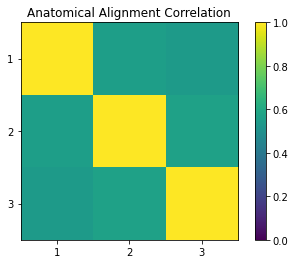

In [8]:
# plot anatomical alignment correlation
anat_corr = anicor(anat_data, anat_data)
plt.imshow(anat_corr)
plt.clim(0,1)
plt.colorbar()
plt.xticks(np.arange(sub_num), range(1,sub_num+1))
plt.yticks(np.arange(sub_num), range(1,sub_num+1))
plt.title('Anatomical Alignment Correlation')
plt.savefig('./anat_corr.png',dpi=200)

In [27]:
# run SRM
num_features = 50

srm = brainiak.funcalign.srm.SRM(n_iter=10, features=num_features)
srm.fit(data)
w = srm.w_
s = srm.s_
print("W shape: ", w[0].shape, "\nS shape: ", s.shape)

W shape:  (20484, 50) 
S shape:  (50, 1180)


In [0]:
# convert shared response data to array
shared_data = []
shared_data_array = np.zeros((sub_num,data[0].shape[0]*data[0].shape[1]))

for i in range(sub_num):
    shared_data.append(np.dot(w[i],s))
    shared_data_array[i,:]=shared_data[i].flatten()

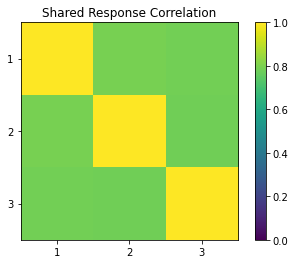

In [11]:
# plot shared response correlation
shared_corr = anicor(shared_data_array, shared_data_array)

plt.imshow(shared_corr)
plt.clim(0,1)
plt.colorbar()
plt.xticks(np.arange(sub_num), range(1,sub_num+1))
plt.yticks(np.arange(sub_num), range(1,sub_num+1))
plt.title('Shared Response Correlation')
plt.savefig('./shared_response_corr.png',dpi=200)

(50, 50)


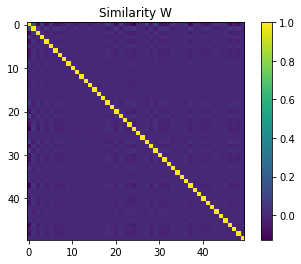

In [24]:
# plot similarity of functional topography W
similarity_w = anicor(w[0].T, w[0].T)
print(similarity_w.shape)

plt.imshow(similarity_w)
plt.colorbar()
plt.title('Similarity W')
plt.savefig('./simi_w1.png',dpi=200)

(1180, 1180)


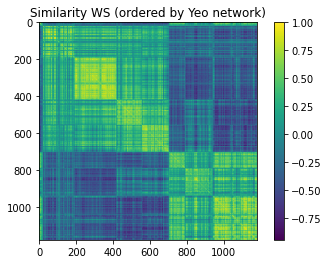

In [25]:
# plot similarity of shared response WS (ordered by Yeo network)
similarity_ws = anicor(shared_data[0].T[np.argsort(yeo_network_1180),:], shared_data[0].T[np.argsort(yeo_network_1180),:])
print(similarity_ws.shape)

plt.imshow(similarity_ws)
plt.colorbar()
plt.title('Similarity WS (ordered by Yeo network)')
plt.savefig('./simi_ws1_yeo.png',dpi=200)

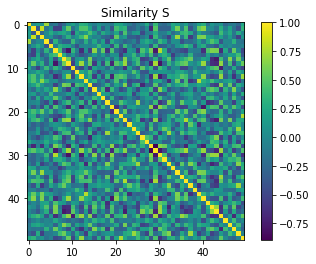

In [28]:
# plot similarity of shared features S
similarity_s = anicor(s, s)
plt.imshow(similarity_s)
plt.colorbar()
plt.title('Similarity S')
plt.savefig('./simi_s.png',dpi=200)

In [15]:
!pip3 install nilearn
from nilearn import surface
from nilearn import plotting
lsurf = surface.load_surf_mesh('%s/resources/10k/Conte69.L.very_inflated.10k_fs_LR.surf.gii' % root_dir)
rsurf = surface.load_surf_mesh('%s/resources/10k/Conte69.R.very_inflated.10k_fs_LR.surf.gii' % root_dir)

     |████████████████████████████████| 2.5MB 11.9MB/s 


In [0]:
# map shared response from 1180 to 20484
shared_response_mapping = np.zeros((num_features,20484))

for i,j in enumerate(ind):
  shared_response_mapping[:,j] = s[:,i]

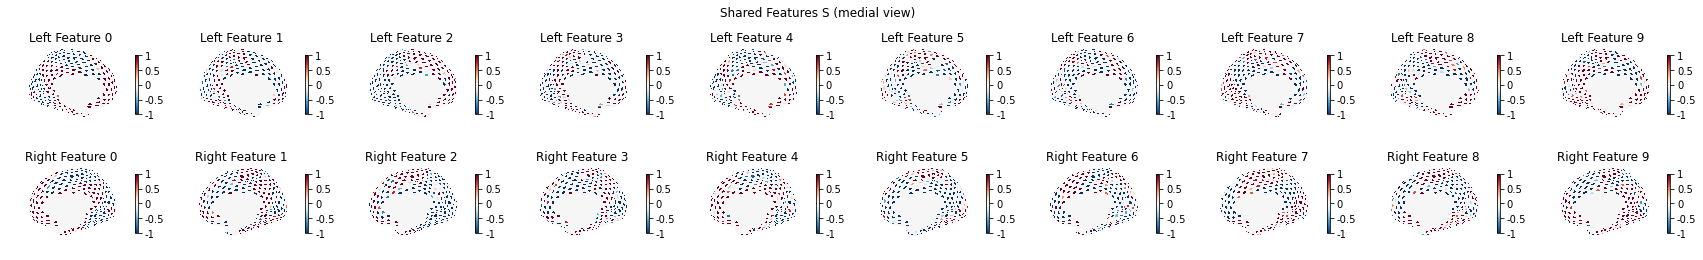

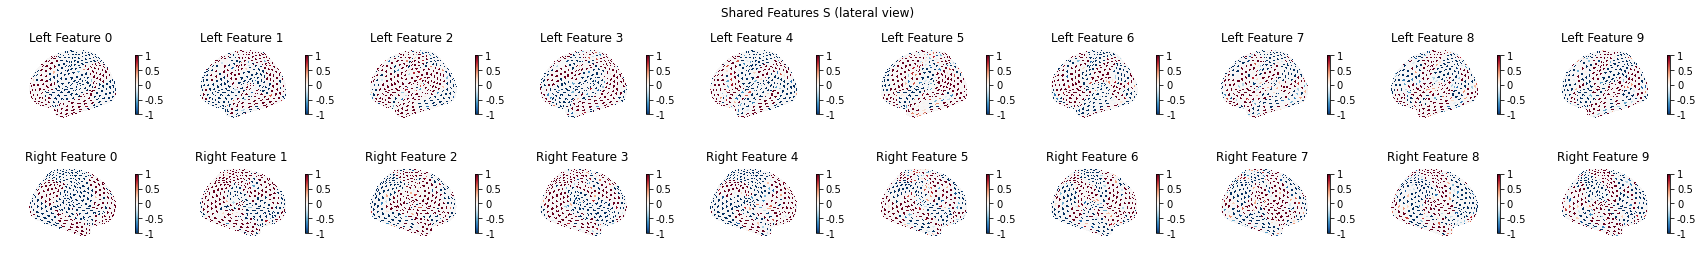

In [17]:
# plot shared features S
for k in ['medial', 'lateral']:
    fig, axes = plt.subplots(nrows=2, ncols=10, subplot_kw={'projection': '3d'},figsize=(30,4))
    fig.suptitle("Shared Features S (%s view)"%(k))
    ax_flat = axes.flat
    for j, ax in enumerate(ax_flat):
        if j < 10:
            i = j
            ax = plotting.plot_surf(lsurf, shared_response_mapping[i,0:10242], hemi='left', title='Left Feature '+str(i), view=k, cmap='RdBu_r', colorbar=True, vmin=-1, vmax=1, alpha=0.5, darkness=0.1, symmetric_cmap=True,axes=ax)
        else:
            i = j-10
            ax = plotting.plot_surf(rsurf, shared_response_mapping[i,10242:], hemi='right', title='Right Feature '+str(i), view=k, cmap='RdBu_r', colorbar=True, vmin=-1, vmax=1, alpha=0.5, darkness=0.1, symmetric_cmap=True,axes=ax)
    plt.savefig('./S_%s.png'%(k), dpi=200)

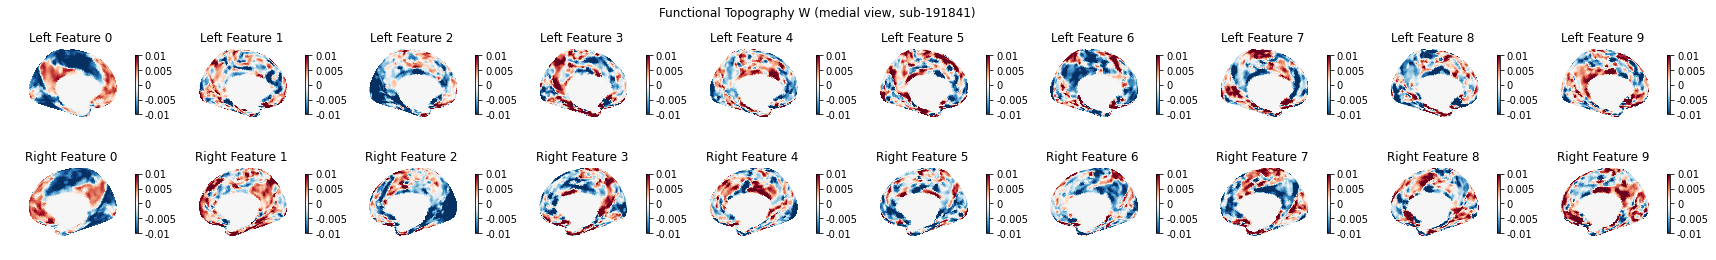

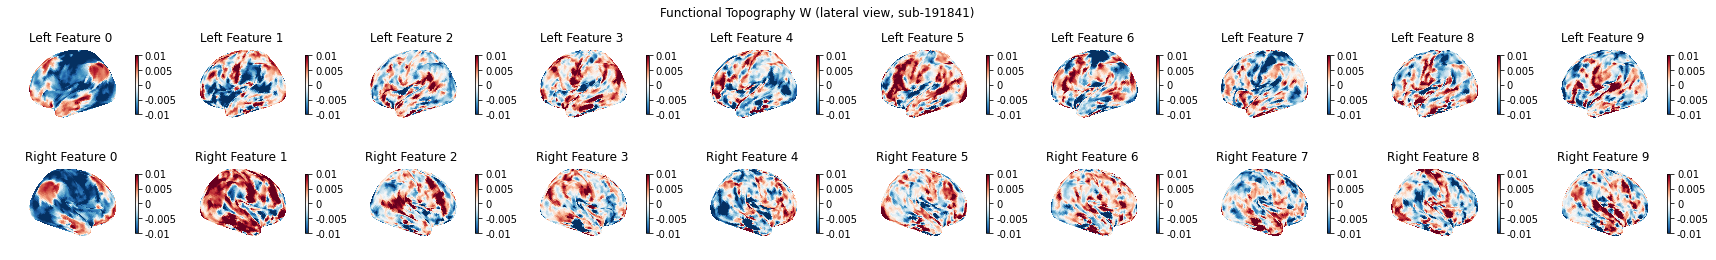

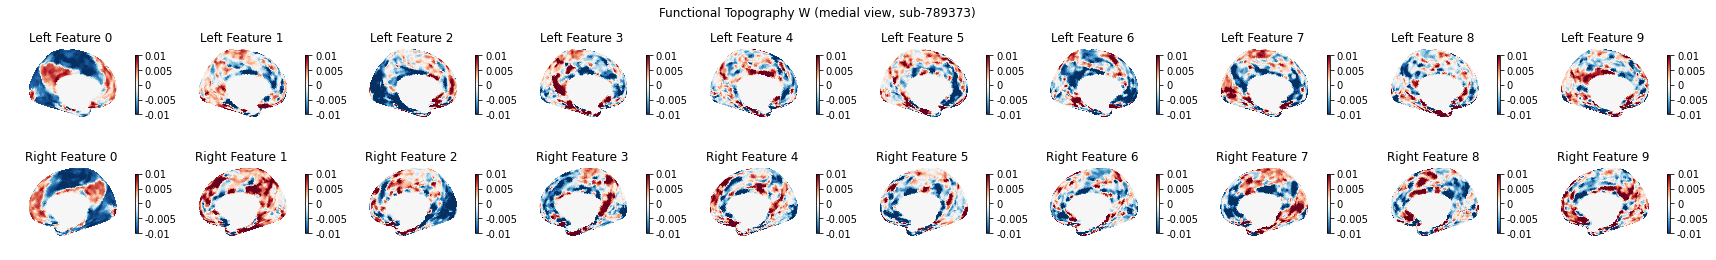

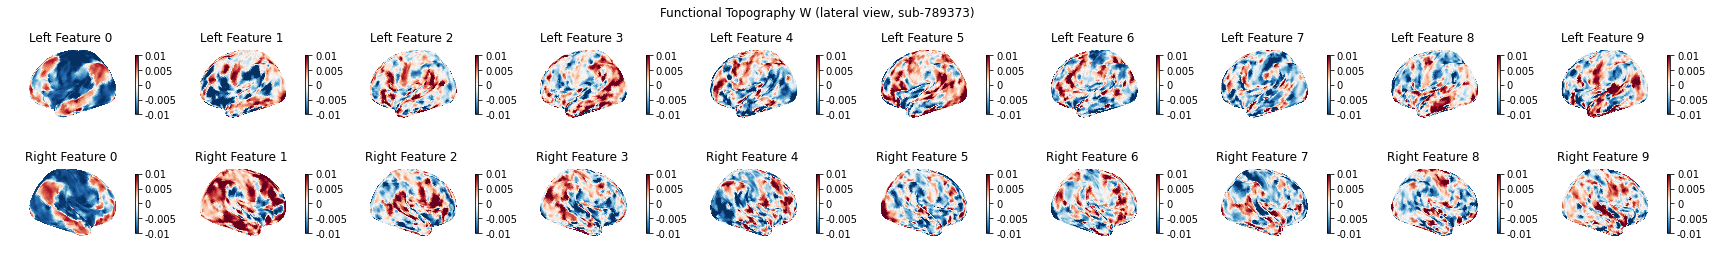

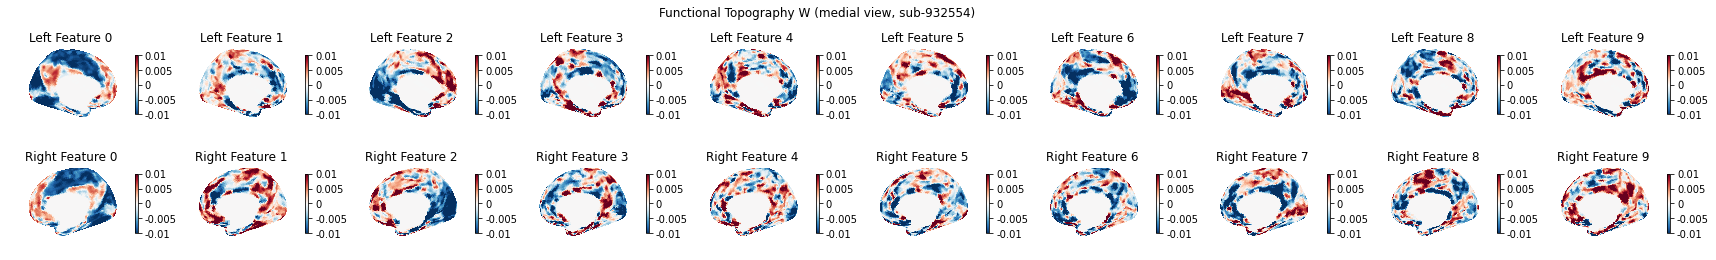

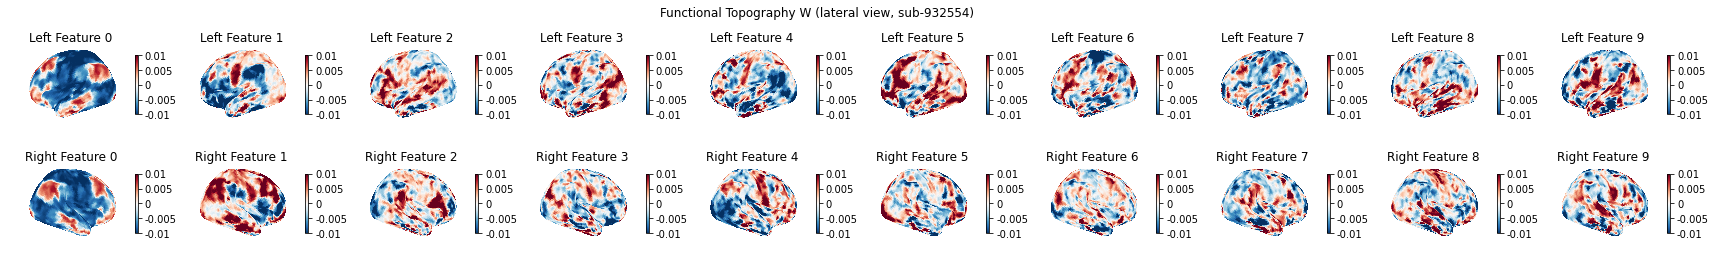

In [20]:
# plot functional topography W
for s, sub in enumerate(sub_list):
  for k in ['medial', 'lateral']:
      fig, axes = plt.subplots(nrows=2, ncols=10, subplot_kw={'projection': '3d'},figsize=(30,4))
      fig.suptitle("Functional Topography W (%s view, sub-%s)"%(k,sub))
      ax_flat = axes.flat
      for j, ax in enumerate(ax_flat):
          if j < 10:
              i = j
              ax = plotting.plot_surf(lsurf, w[s][0:10242,i], hemi='left', title='Left Feature '+str(i), view=k, cmap='RdBu_r', colorbar=True, vmin=-0.01, vmax=0.01, alpha=0.5, darkness=0.1, symmetric_cmap=True,axes=ax)
          else:
              i = j-10
              ax = plotting.plot_surf(rsurf, w[s][10242:,i], hemi='right', title='Right Feature '+str(i), view=k, cmap='RdBu_r', colorbar=True, vmin=-0.01, vmax=0.01, alpha=0.5, darkness=0.1, symmetric_cmap=True,axes=ax)
      plt.savefig('./W_%s_sub-%s.png'%(k,sub), dpi=200)

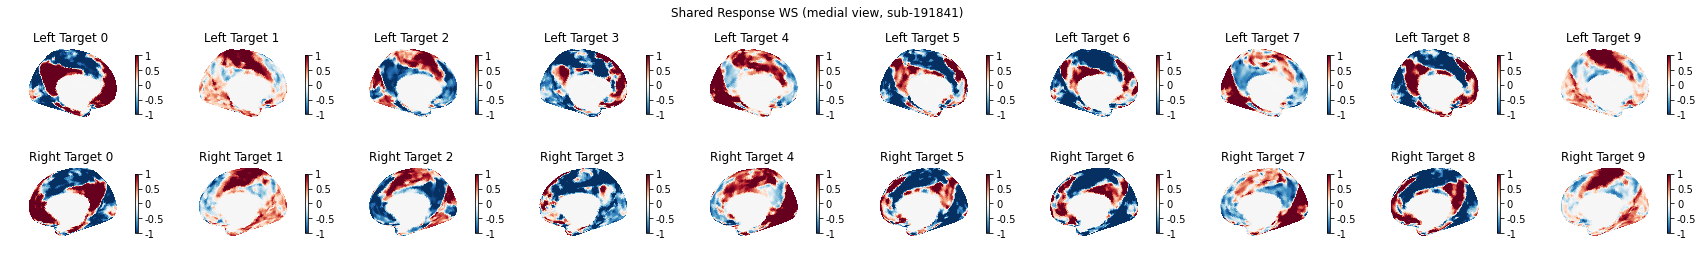

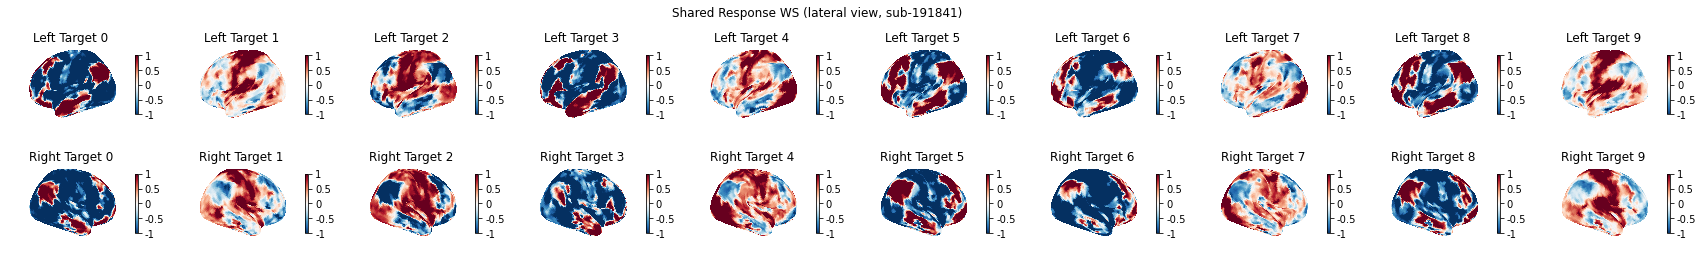

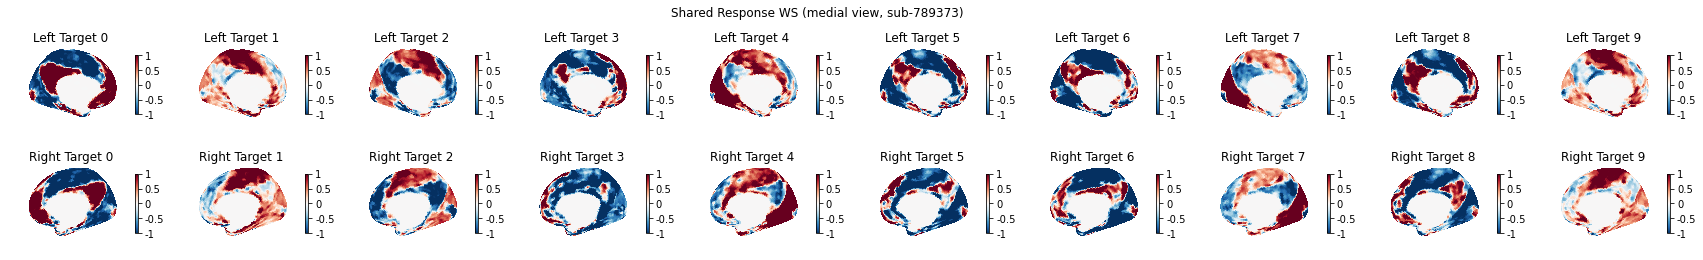

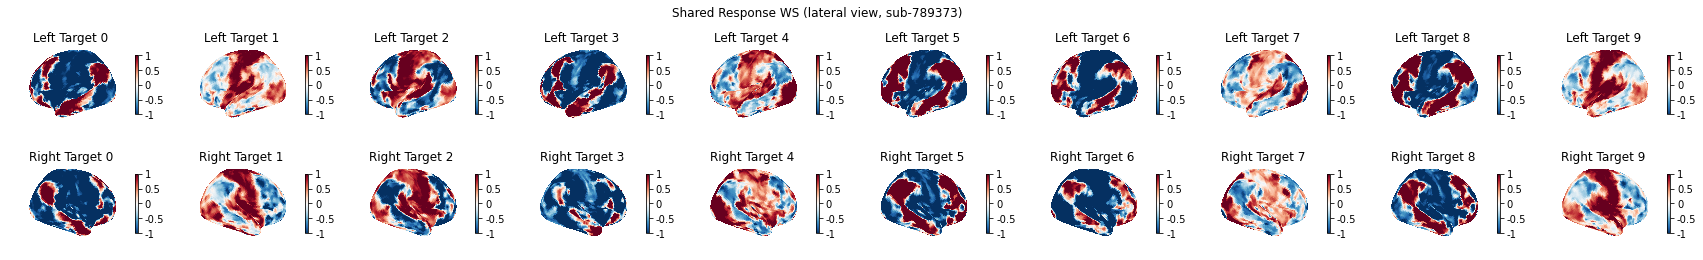

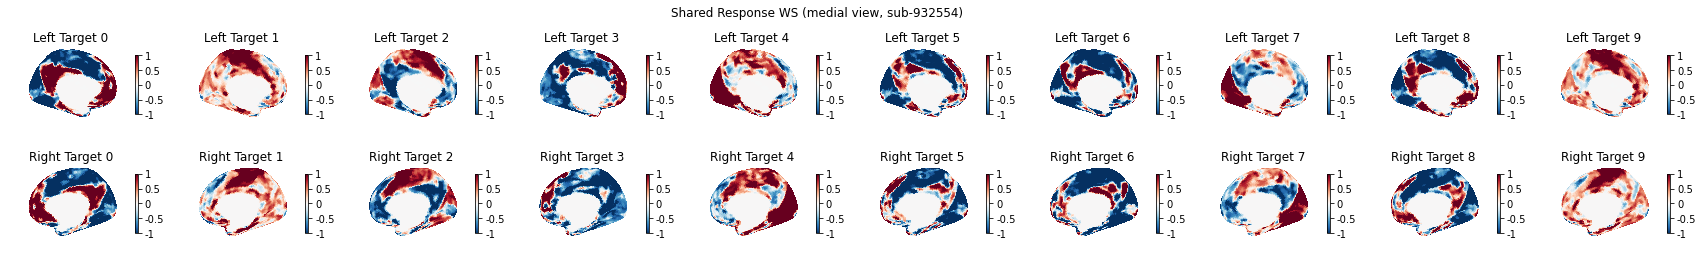

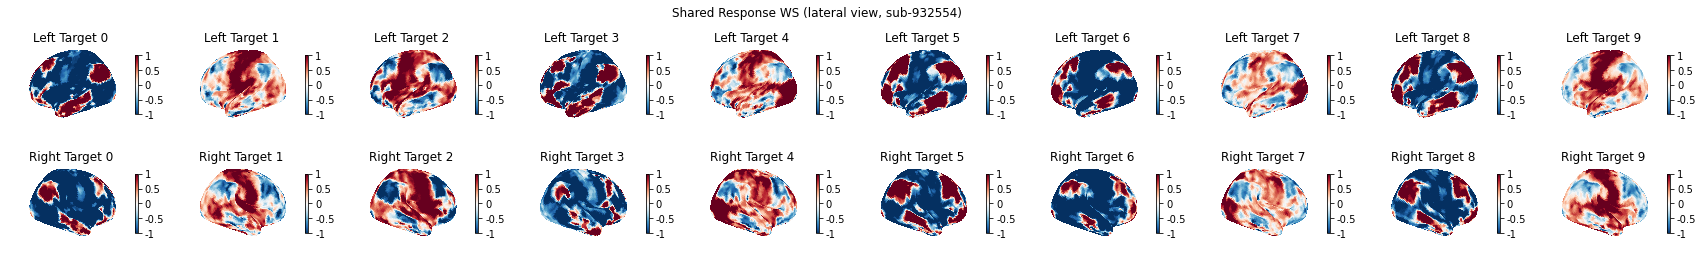

In [21]:
# plot shared response WS
for s, sub in enumerate(sub_list):
  for k in ['medial', 'lateral']:
      fig, axes = plt.subplots(nrows=2, ncols=10, subplot_kw={'projection': '3d'},figsize=(30,4))
      fig.suptitle("Shared Response WS (%s view, sub-%s)"%(k,sub))
      ax_flat = axes.flat
      for j, ax in enumerate(ax_flat):
          if j < 10:
              i = j
              ax = plotting.plot_surf(lsurf, shared_data[s][0:10242,i], hemi='left', title='Left Target '+str(i), view=k, cmap='RdBu_r', colorbar=True, vmin=-1, vmax=1, alpha=0.5, darkness=0.1, symmetric_cmap=True,axes=ax)
          else:
              i = j-10
              ax = plotting.plot_surf(rsurf, shared_data[s][10242:,i], hemi='right', title='Right Target '+str(i), view=k, cmap='RdBu_r', colorbar=True, vmin=-1, vmax=1, alpha=0.5, darkness=0.1, symmetric_cmap=True,axes=ax)
      plt.savefig('./WS_%s_sub-%s.png'%(k,sub), dpi=200)

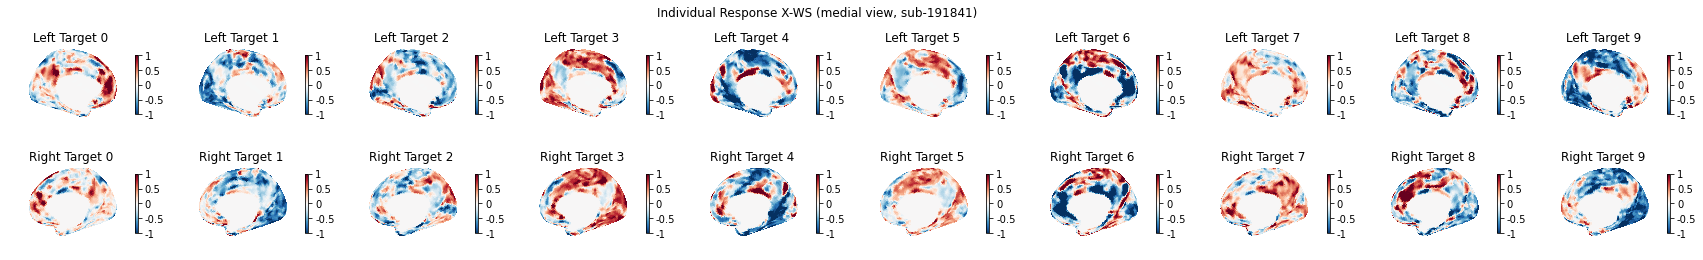

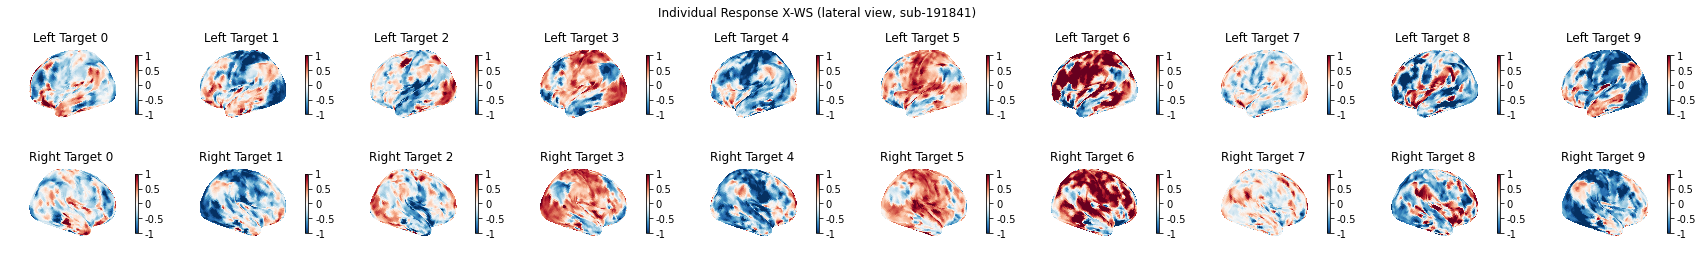

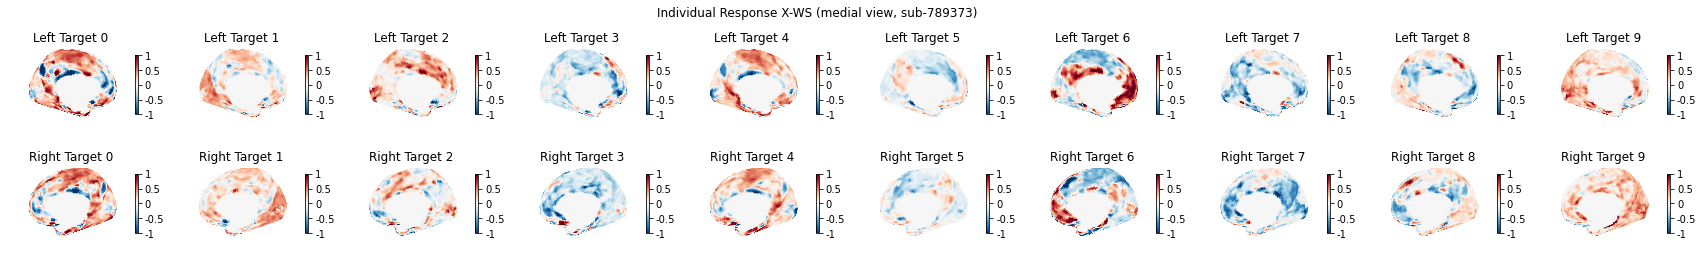

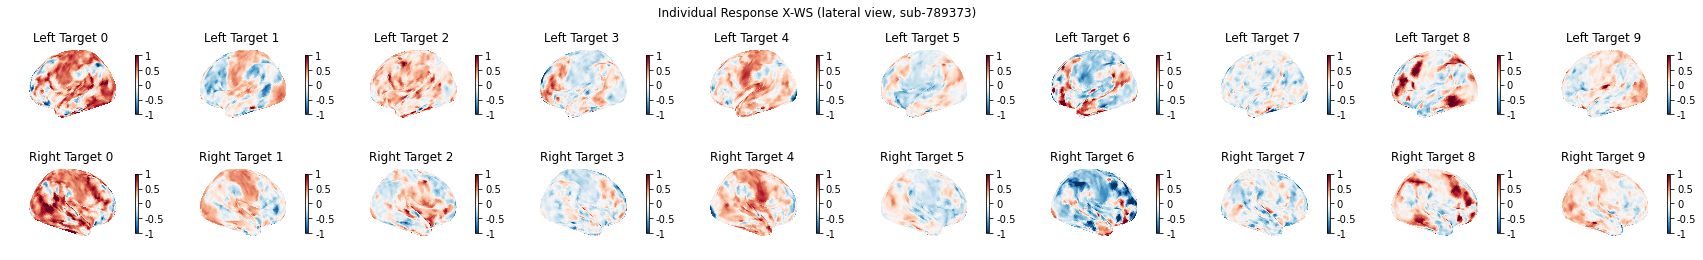

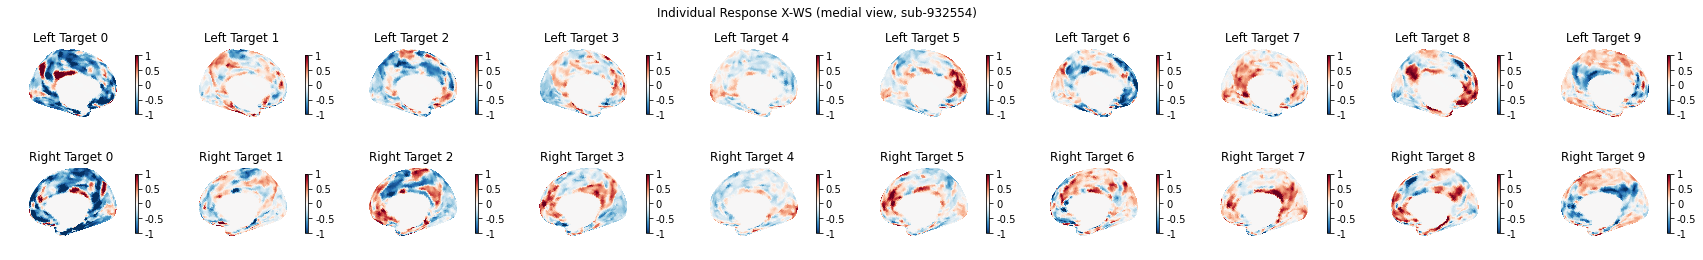

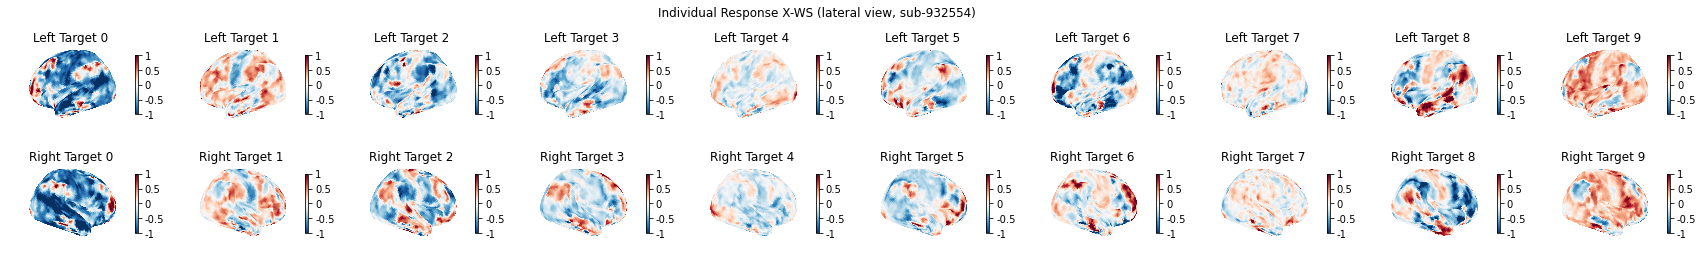

In [23]:
# plot individual response X-WS
for s, sub in enumerate(sub_list):
  for k in ['medial', 'lateral']:
      fig, axes = plt.subplots(nrows=2, ncols=10, subplot_kw={'projection': '3d'},figsize=(30,4))
      fig.suptitle("Individual Response X-WS (%s view, sub-%s)"%(k,sub))
      ax_flat = axes.flat
      individual_data = data[s]-shared_data[s]
      for j, ax in enumerate(ax_flat):
          if j < 10:
              i = j
              ax = plotting.plot_surf(lsurf, individual_data[0:10242,i], hemi='left', title='Left Target '+str(i), view=k, cmap='RdBu_r', colorbar=True, vmin=-1, vmax=1, alpha=0.5, darkness=0.1, symmetric_cmap=True,axes=ax)
          else:
              i = j-10
              ax = plotting.plot_surf(rsurf, individual_data[10242:,i], hemi='right', title='Right Target '+str(i), view=k, cmap='RdBu_r', colorbar=True, vmin=-1, vmax=1, alpha=0.5, darkness=0.1, symmetric_cmap=True,axes=ax)
      plt.savefig('./X-WS_%s_sub-%s.png'%(k,sub), dpi=200)

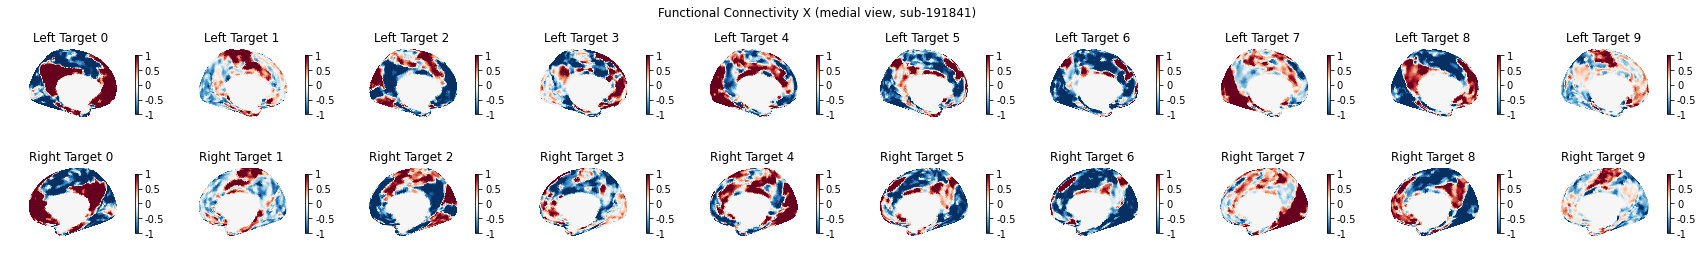

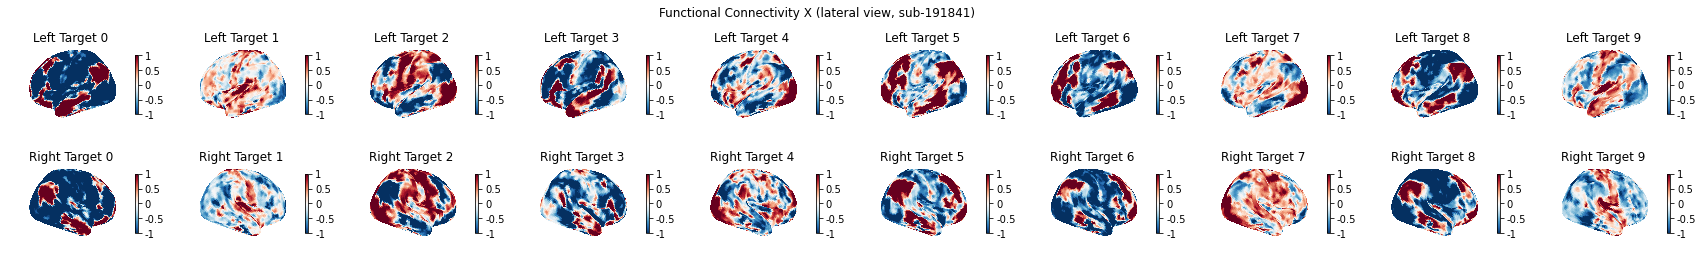

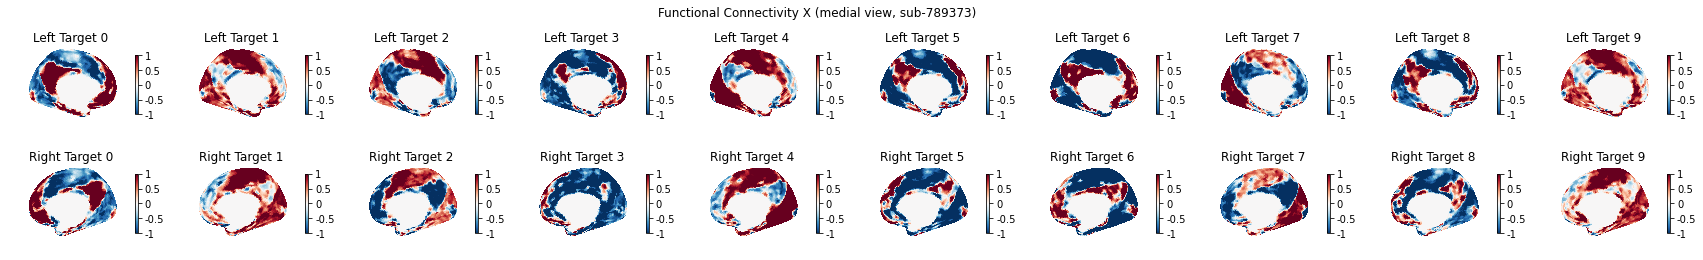

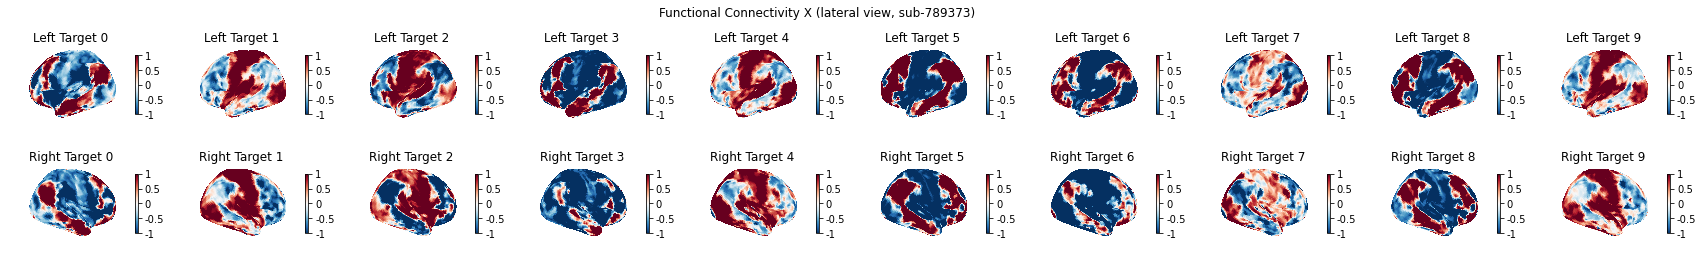

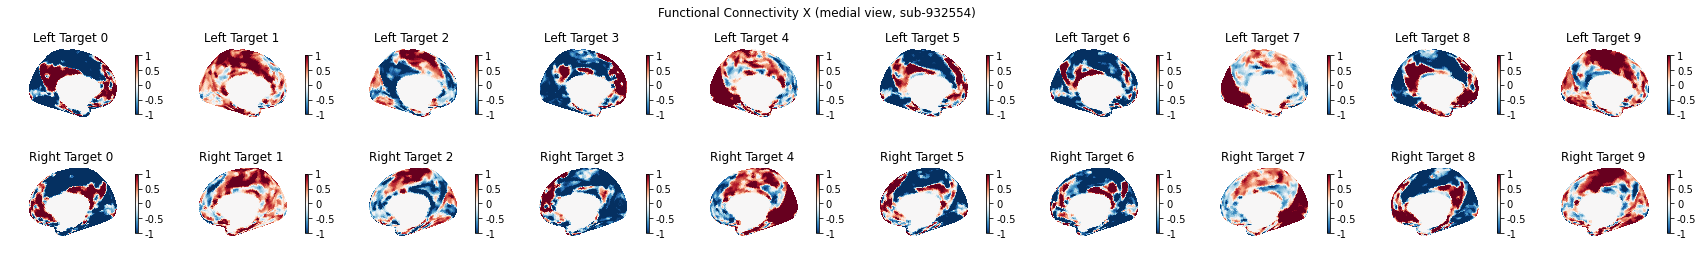

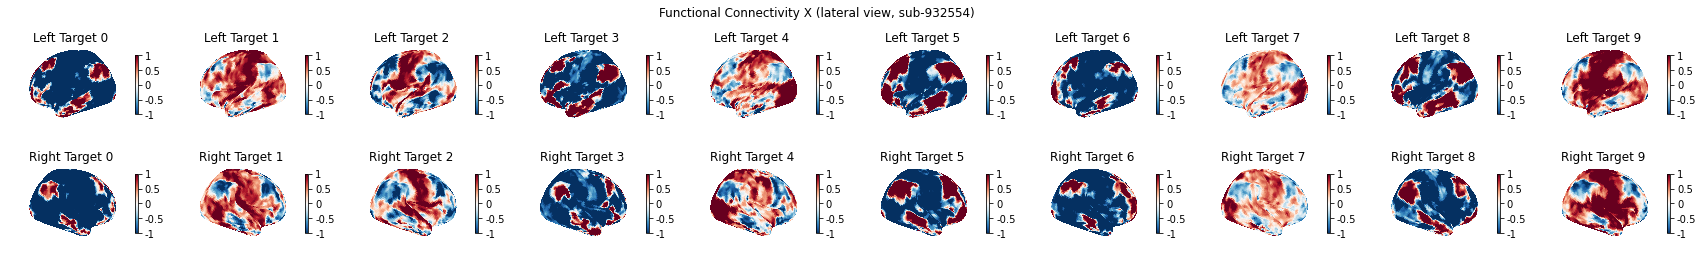

In [29]:
# plot original data
for s, sub in enumerate(sub_list):
  for k in ['medial', 'lateral']:
      fig, axes = plt.subplots(nrows=2, ncols=10, subplot_kw={'projection': '3d'},figsize=(30,4))
      fig.suptitle("Functional Connectivity X (%s view, sub-%s)"%(k,sub))
      ax_flat = axes.flat
      for j, ax in enumerate(ax_flat):
          if j < 10:
              i = j
              ax = plotting.plot_surf(lsurf, data[s][0:10242,i], hemi='left', title='Left Target '+str(i), view=k, cmap='RdBu_r', colorbar=True, vmin=-1, vmax=1, alpha=0.5, darkness=0.1, symmetric_cmap=True,axes=ax)
          else:
              i = j-10
              ax = plotting.plot_surf(rsurf, data[s][10242:,i], hemi='right', title='Right Target '+str(i), view=k, cmap='RdBu_r', colorbar=True, vmin=-1, vmax=1, alpha=0.5, darkness=0.1, symmetric_cmap=True,axes=ax)
      plt.savefig('./X_%s_sub-%s.png'%(k,sub), dpi=200)